In [ ]:
%run ../utils/box_evaluation.py

In [ ]:
import os
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/luka/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/luka/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Find the optimal confidence threshold on the validation set

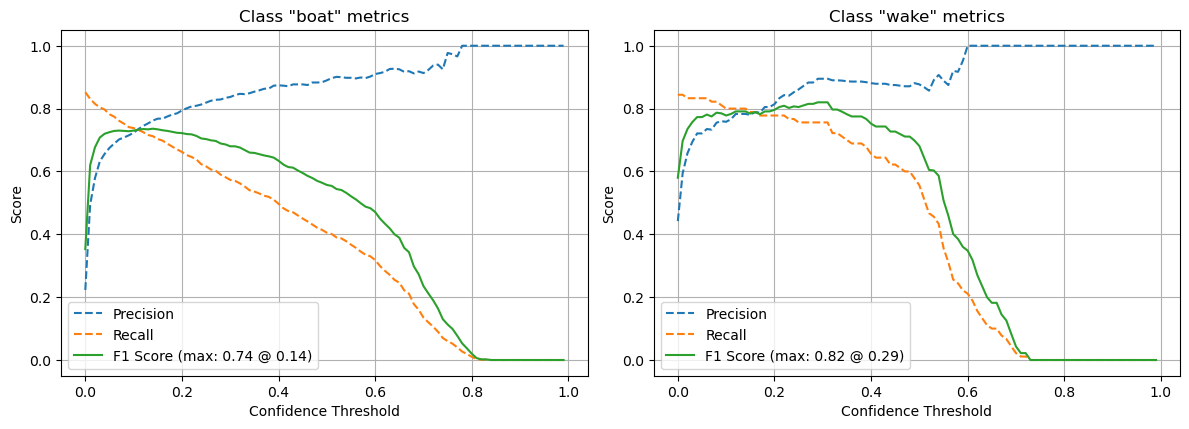

In [ ]:
gt_folder = "../A_dataset/dataset/labels/val"
pred_folder = "predict/val"
iou_threshold = 0.3
conf_list = list(np.arange(0, 1, 0.01))
labels = ["boat", "wake"]

all_precision = []
all_recall = []
all_f1 = []

for conf in conf_list:
    cm = compute_confusion_matrix(gt_folder, pred_folder, iou_threshold, {0: conf, 1: conf})
    
    precision, recall, f1 = compute_precision_recall_f1(cm)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)

plt.figure(figsize=(12, 8))
for class_id in range(len(labels)):

    precisions = [all_precision[i][class_id] for i in range(len(all_precision))]
    recalls = [all_recall[i][class_id] for i in range(len(all_recall))]
    f1_scores = [all_f1[i][class_id] for i in range(len(all_f1))]

    plt.subplot(2, 2, class_id + 1)
    plt.plot(conf_list, precisions, label=f'Precision', linestyle='--')
    plt.plot(conf_list, recalls, label=f'Recall', linestyle='--')
    plt.plot(conf_list, f1_scores, label=f'F1 Score (max: {max(f1_scores):.2f} @ {conf_list[f1_scores.index(max(f1_scores))]:.2f})')
    plt.title(f'Class "{labels[class_id]}" metrics')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Score')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

Use the optimal thresholds of the validation set to evaluate the test set

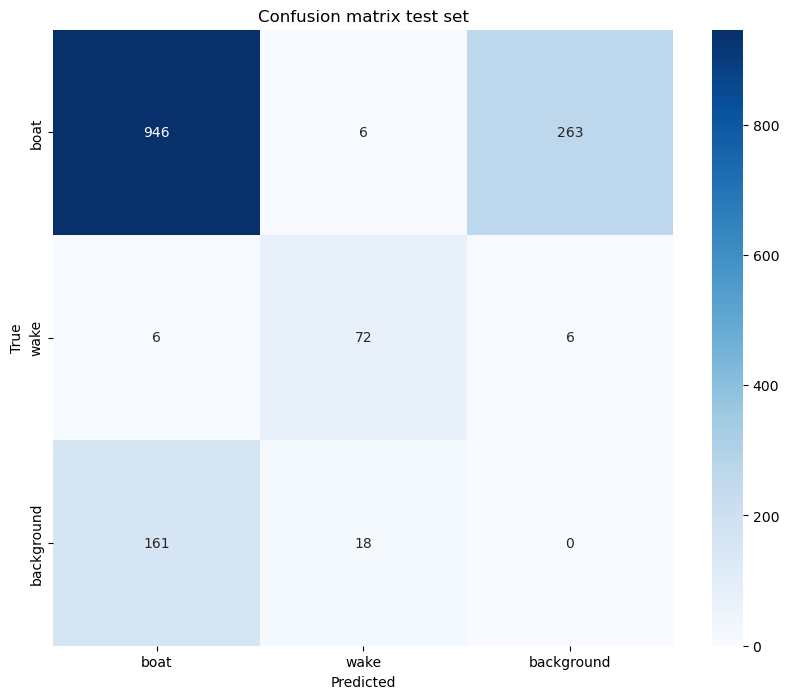

Precision: {0: 0.85, 1: 0.75, 2: 0.0}
Recall: {0: 0.779, 1: 0.857, 2: 0.0}
F1 Score: {0: 0.813, 1: 0.8, 2: 0}


In [3]:
gt_folder = "../A_dataset/dataset/labels/test"
pred_folder = "predict/test"
iou_threshold = 0.3
confidence_thresholds = {0: 0.14, 1: 0.29}
labels = ["boat", "wake", "background"]




cm = compute_confusion_matrix(gt_folder, pred_folder, iou_threshold, confidence_thresholds)
plot_confusion_matrix(cm, labels, "Confusion matrix test set")

precision, recall, f1 = compute_precision_recall_f1(cm)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

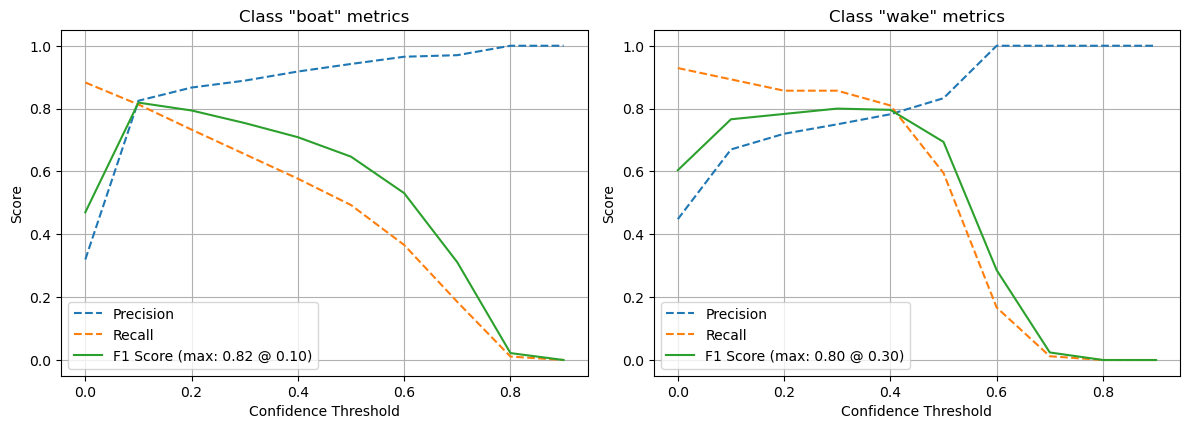

In [3]:
gt_folder = "../A_dataset/dataset/labels/test"
pred_folder = "predict/test"
iou_threshold = 0.3
conf_list = list(np.arange(0, 1, 0.1))
labels = ["boat", "wake"]




all_precision = []
all_recall = []
all_f1 = []

for conf in conf_list:
    cm = compute_confusion_matrix(gt_folder, pred_folder, iou_threshold, {0: conf, 1: conf})
    
    precision, recall, f1 = compute_precision_recall_f1(cm)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)

plt.figure(figsize=(12, 8))
for class_id in range(len(labels)):

    precisions = [all_precision[i][class_id] for i in range(len(all_precision))]
    recalls = [all_recall[i][class_id] for i in range(len(all_recall))]
    f1_scores = [all_f1[i][class_id] for i in range(len(all_f1))]

    plt.subplot(2, 2, class_id + 1)
    plt.plot(conf_list, precisions, label=f'Precision', linestyle='--')
    plt.plot(conf_list, recalls, label=f'Recall', linestyle='--')
    plt.plot(conf_list, f1_scores, label=f'F1 Score (max: {max(f1_scores):.2f} @ {conf_list[f1_scores.index(max(f1_scores))]:.2f})')
    plt.title(f'Class "{labels[class_id]}" metrics')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Score')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

----

Study the class "boat" lengths

In [5]:
gt_folder = "../A_dataset/dataset/labels/test"
pred_folder = "predict/test"
iou_threshold = 0.3
confidence_threshold = 0.14

all_gt_lengths, all_pred_lengths = match(gt_folder, pred_folder, iou_threshold, confidence_threshold, classes=[0])

Mean Absolute Error: 3.91
Mean Squared Error: 173.56
Root Mean Squared Error: 13.17
Mean Absolute Percentage Error: 17.14
R2 Score: 0.92


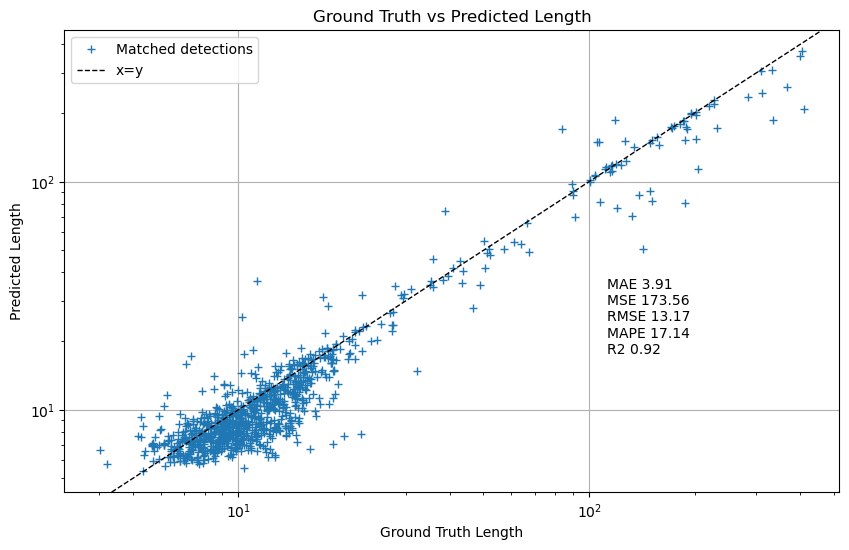

In [6]:
# remove unmatched objects
gt_lengths, pred_lengths = [], []
for gt, pred in zip(all_gt_lengths, all_pred_lengths):
    if gt == -1 or pred == -1:
        continue
    gt_lengths.append(gt)
    pred_lengths.append(pred)

# filter by length
gt_lengths_subset, pred_lengths_subset = [], []
for gt, pred in zip(gt_lengths, pred_lengths):
    if gt >= 0 and gt <= 500:
        gt_lengths_subset.append(gt)
        pred_lengths_subset.append(pred)

# plot gt against pred
plt.figure(figsize=(10, 6))
plt.plot(gt_lengths_subset, pred_lengths_subset, '+', label="Matched detections")
plt.axline((0, 0), slope=1, linestyle='--', color='black', lw=1, label="x=y")
plt.xlabel('Ground Truth Length')
plt.ylabel('Predicted Length')
plt.title('Ground Truth vs Predicted Length')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()


# MAE
mae = np.mean(np.abs(np.array(gt_lengths_subset) - np.array(pred_lengths_subset)))
print(f'Mean Absolute Error: {mae:.2f}')

# MSE
mse = np.mean((np.array(gt_lengths_subset) - np.array(pred_lengths_subset)) ** 2)
print(f'Mean Squared Error: {mse:.2f}')

# RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.2f}')

# MAPE
mape = np.mean(np.abs((np.array(gt_lengths_subset) - np.array(pred_lengths_subset)) / np.array(gt_lengths_subset))) * 100
print(f'Mean Absolute Percentage Error: {mape:.2f}')

# R2
r2 = 1 - (np.sum((np.array(gt_lengths_subset) - np.array(pred_lengths_subset)) ** 2) / np.sum((np.array(gt_lengths_subset) - np.mean(gt_lengths_subset)) ** 2))
print(f'R2 Score: {r2:.2f}')

# add performances to the plot
text = f"MAE {mae:.2f}\nMSE {mse:.2f}\nRMSE {rmse:.2f}\nMAPE {mape:.2f}\nR2 {r2:.2f}"
plt.text(0.7, 0.3, text, transform=plt.gca().transAxes)

plt.show()

Study missed detections

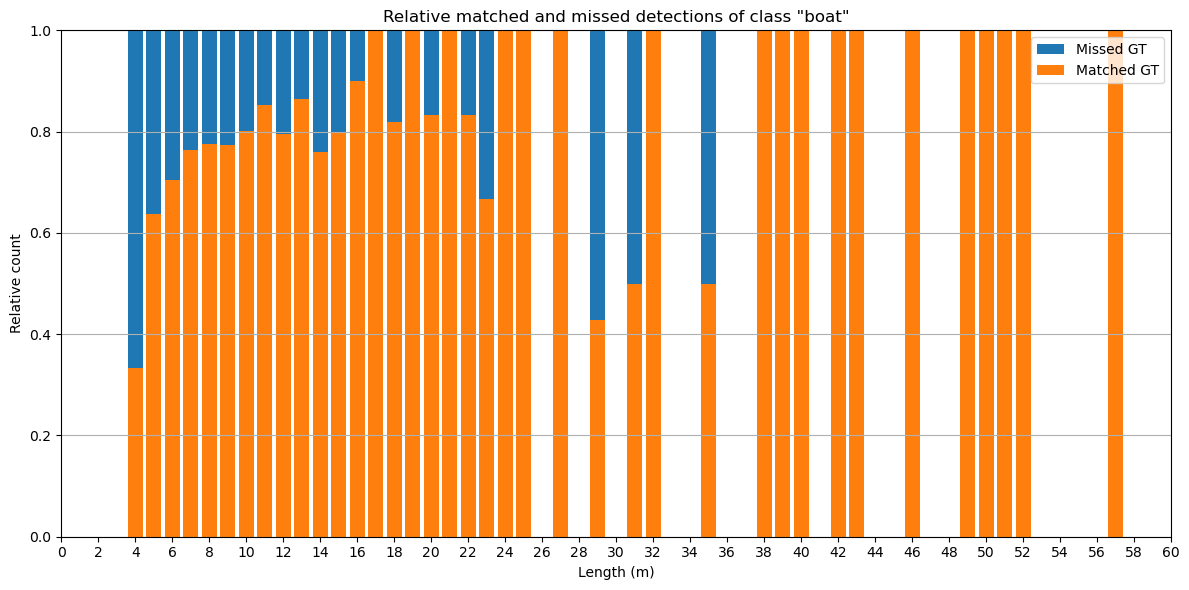

Matched GT lengths: [11.014454386478143, 116.28495817506982, 115.83262625634988, 46.73747105926647, 13.374003204037692, 23.14107251136774, 27.43531238599929, 18.606463407567915, 10.519002684178318, 8.182400943839681, 12.055596537942996, 12.399922852176346, 10.09288225550575, 10.615757763099857, 9.222123294449165, 13.164826867534117, 7.907336725262802, 9.235881749593528, 6.972325592210929, 7.30017593091204, 10.694782943013408, 7.975684886734854, 11.160432278601064, 10.0367938744057, 7.655998780695285, 9.416817744728615, 8.66975636313694, 7.825933714946803, 8.56394040005393, 7.35396353751598, 7.409049955978119, 7.255566603464992, 7.861144071568901, 7.613779483800144, 9.168463240724126, 6.385941997772935, 7.78284761764899, 7.373416118427738, 7.812029909136136, 7.405793095648669, 7.384174400268986, 7.610728237014129, 6.403152376849015, 6.782738274374395, 104.16328073308087, 20.005251948532802, 51.85938107522537, 39.6276420310148, 42.73176132908635, 22.644840989215908, 40.86374415273404, 15

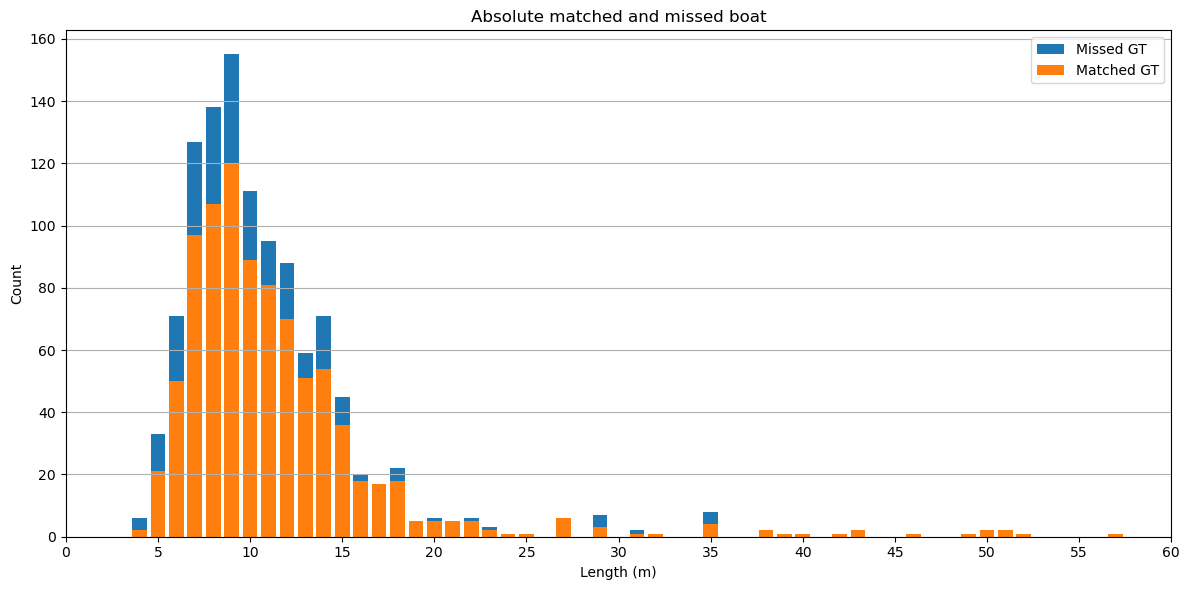

In [16]:
# discriminate results
missed_gt_lengths, missed_pred_lengths = [], []
gt_lengths, pred_lengths = [], []
for gt, pred in zip(all_gt_lengths, all_pred_lengths):
    if gt == -1:
        missed_pred_lengths.append(pred)
    elif pred == -1:
        missed_gt_lengths.append(gt)
    else:
        gt_lengths.append(gt)
        pred_lengths.append(pred)


# group length by size (make groups of 1 m)
def group_lengths(lengths):
    grouped = {k: 0 for k in range(500)}
    for length in lengths:
        if length == -1:
            continue
        # Group by 1m intervals
        key = int(length)
        grouped[key] += 1
    return dict(sorted(grouped.items()))


# Group lengths
grouped_all_gt_lengths = group_lengths(all_gt_lengths)
grouped_all_pred_lengths = group_lengths(all_pred_lengths)

grouped_gt_lengths = group_lengths(gt_lengths)
grouped_pred_lengths = group_lengths(pred_lengths)

relative_matched_gt_lengths = {k: grouped_gt_lengths.get(k, 0) / grouped_all_gt_lengths.get(k, 1) if grouped_all_gt_lengths.get(k, 1) > 0 else 0 for k in grouped_all_gt_lengths}
relative_matched_pred_lengths = {k: grouped_pred_lengths.get(k, 0) / grouped_all_pred_lengths.get(k, 1) if grouped_all_pred_lengths.get(k, 1) > 0 else 0 for k in grouped_all_pred_lengths}

grouped_missed_gt_lengths = group_lengths(missed_gt_lengths)
grouped_missed_pred_lengths = group_lengths(missed_pred_lengths)

relative_missed_gt = {k: grouped_missed_gt_lengths.get(k, 0) / grouped_all_gt_lengths.get(k, 1) if grouped_all_gt_lengths.get(k, 1) > 0 else 0 for k in grouped_all_gt_lengths}
relative_missed_pred = {k: grouped_missed_pred_lengths.get(k, 0) / grouped_all_pred_lengths.get(k, 1) if grouped_all_pred_lengths.get(k, 1) > 0 else 0 for k in grouped_all_pred_lengths}

# plot missed and matched relative distribution stacked on top of each other
plt.figure(figsize=(12, 6))
plt.bar(relative_missed_gt.keys(), relative_missed_gt.values(), label="Missed GT", bottom=list(relative_matched_gt_lengths.values()))
plt.bar(relative_matched_gt_lengths.keys(), relative_matched_gt_lengths.values(), label="Matched GT")
plt.title("Relative matched and missed detections of class \"boat\"")
plt.xlabel("Length (m)")
plt.ylabel("Relative count")
plt.xlim(0, 60)
plt.xticks(range(0, 61, 2))
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

print("Matched GT lengths:", gt_lengths)
print("Missed GT lengths:", missed_gt_lengths)

# plot missed and matched absolute distribution stacked on top of each other
plt.figure(figsize=(12, 6))
plt.bar(grouped_missed_gt_lengths.keys(), grouped_missed_gt_lengths.values(), label="Missed GT", bottom=list(grouped_gt_lengths.values()))
plt.bar(grouped_gt_lengths.keys(), grouped_gt_lengths.values(), label="Matched GT")
plt.title("Absolute matched and missed boat")
plt.xlabel("Length (m)")
plt.ylabel("Count")
plt.xlim(0, 60)
plt.xticks(range(0, 61, 5))
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def group_boat_lengths(lengths, n_groups=5):

    lengths = np.array(lengths)
    quantiles = np.linspace(0, 1, n_groups + 1)
    bins = np.quantile(lengths, quantiles)

    # Digitize assigns each value into a bin index
    groups = np.digitize(lengths, bins[1:-1], right=True) + 1

    # Build readable bin ranges
    bin_ranges = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]

    # values per group
    values_per_group = [lengths[groups == i].tolist() for i in range(1, n_groups + 1)]

    return groups.tolist(), bin_ranges, values_per_group


all_gt_lengths_without_neg = list(filter(lambda x: x >= 0, all_gt_lengths))
groups, ranges, values = group_boat_lengths(all_gt_lengths_without_neg, n_groups=20)
# values = values[:-1]
# ranges = ranges[:-1]

for i, (min, maxi) in enumerate(ranges):
    print(f"group {i+1}: <= {maxi:.2f} with {len(values[i])} values")


group 1: <= 6.40 with 62 values
group 2: <= 7.13 with 60 values
group 3: <= 7.68 with 62 values
group 4: <= 8.06 with 59 values
group 5: <= 8.55 with 61 values
group 6: <= 8.98 with 61 values
group 7: <= 9.27 with 60 values
group 8: <= 9.63 with 61 values
group 9: <= 10.14 with 61 values
group 10: <= 10.62 with 61 values
group 11: <= 11.28 with 60 values
group 12: <= 11.92 with 61 values
group 13: <= 12.61 with 61 values
group 14: <= 13.39 with 62 values
group 15: <= 14.49 with 59 values
group 16: <= 15.29 with 61 values
group 17: <= 17.93 with 60 values
group 18: <= 29.06 with 64 values
group 19: <= 115.86 with 58 values
group 20: <= 410.74 with 61 values


Check class "boat" detection performances depending on length

In [96]:
def assign_new_class(poly_pts, classes):
    poly = Polygon(np.array(poly_pts).reshape(4, 2))
    
    coords = np.array(poly.exterior.coords)[:-1]
    edges = np.linalg.norm(coords - np.roll(coords, 1, axis=0), axis=1)
    longest_edge = np.max(edges)
    
    for i, (class_id, class_length) in enumerate(classes.items()):
        if longest_edge < class_length:
            return i
        
    return -1

In [97]:
gt_folder = "../A_dataset/dataset/labels/test"
pred_folder = "predict/test"
tmp_folder = "tmp"
length_classes = [round(maxi, 2) for _, maxi in ranges]
image_size = 512 # length of a side of the squared image in pixels
pixel_resolution = 3 # in meters
size_adjust = 4 # number of pixels added to the box per direction


# copy directory contents to tmp
if os.path.exists(tmp_folder):
    os.system(f"rm -rf {tmp_folder}")
tmp_predictions = os.path.join(tmp_folder, "predictions")
tmp_groundtruth = os.path.join(tmp_folder, "groundtruth")
os.makedirs(tmp_predictions, exist_ok=True)
os.makedirs(tmp_groundtruth, exist_ok=True)

for file in os.listdir(pred_folder):
    os.system(f"cp {os.path.join(pred_folder, file)} {os.path.join(tmp_predictions, file)}")

for file in os.listdir(gt_folder):
    os.system(f"cp {os.path.join(gt_folder, file)} {os.path.join(tmp_groundtruth, file)}")


# remove class 1
list_files_pred = [os.path.join(tmp_predictions, file) for file in os.listdir(tmp_predictions) if file.endswith('.txt')]
list_files_gt = [os.path.join(tmp_groundtruth, file) for file in os.listdir(tmp_groundtruth) if file.endswith('.txt')]
for file in list_files_pred + list_files_gt:
    with open(file, 'r') as f:
        lines = f.readlines()
    with open(file, 'w') as f:
        for line in lines:
            parts = line.strip().split()
            cls = int(parts[0])
            if cls == 1:
                continue
            f.write(line)

# reassign new classes based on box length
classes = {i:((length_classes[i] / pixel_resolution) + size_adjust) / image_size  for i in range(len(length_classes))} # Normalize length to 0-1 based on the fixed image size and resolution
print(classes)

list_files_pred = [os.path.join(tmp_predictions, file) for file in os.listdir(tmp_predictions) if file.endswith('.txt')]
list_files_gt = [os.path.join(tmp_groundtruth, file) for file in os.listdir(tmp_groundtruth) if file.endswith('.txt')]
for file in list_files_pred + list_files_gt:
    with open(file, 'r') as f:
        lines = f.readlines()
    with open(file, 'w') as f:
        for line in lines:
            parts = line.strip().split()
            cls = int(parts[0])
            new_cls = assign_new_class(list(map(float, parts[1:9])), classes)
            if new_cls == -1:
                continue
            parts[0] = str(new_cls)
            f.write(' '.join(parts) + '\n')

{0: 0.011979166666666666, 1: 0.012454427083333334, 2: 0.012812500000000001, 3: 0.013059895833333335, 4: 0.01337890625, 5: 0.013658854166666668, 6: 0.01384765625, 7: 0.014082031250000002, 8: 0.014414062500000002, 9: 0.014726562499999998, 10: 0.01515625, 11: 0.015572916666666665, 12: 0.016022135416666666, 13: 0.01652994791666667, 14: 0.01724609375, 15: 0.017766927083333335, 16: 0.019485677083333333, 17: 0.02673177083333333, 18: 0.0832421875, 19: 0.27522135416666665}


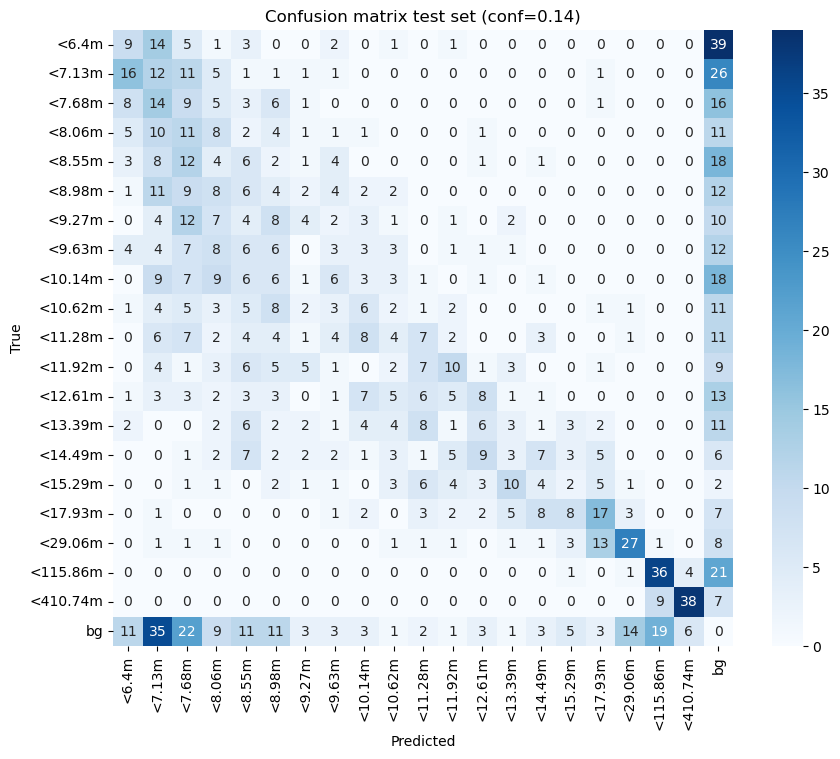

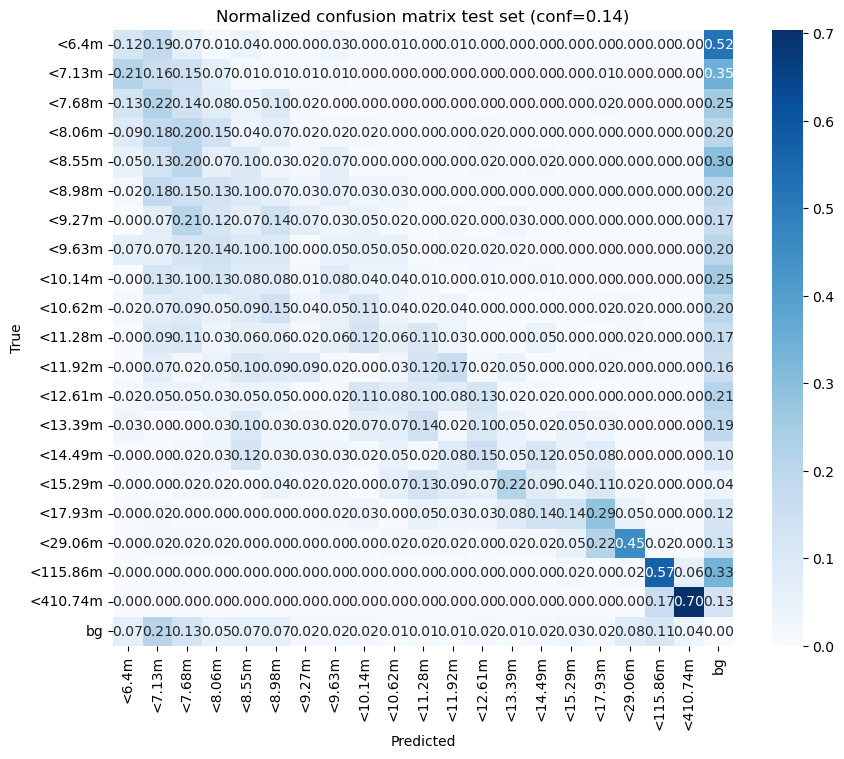

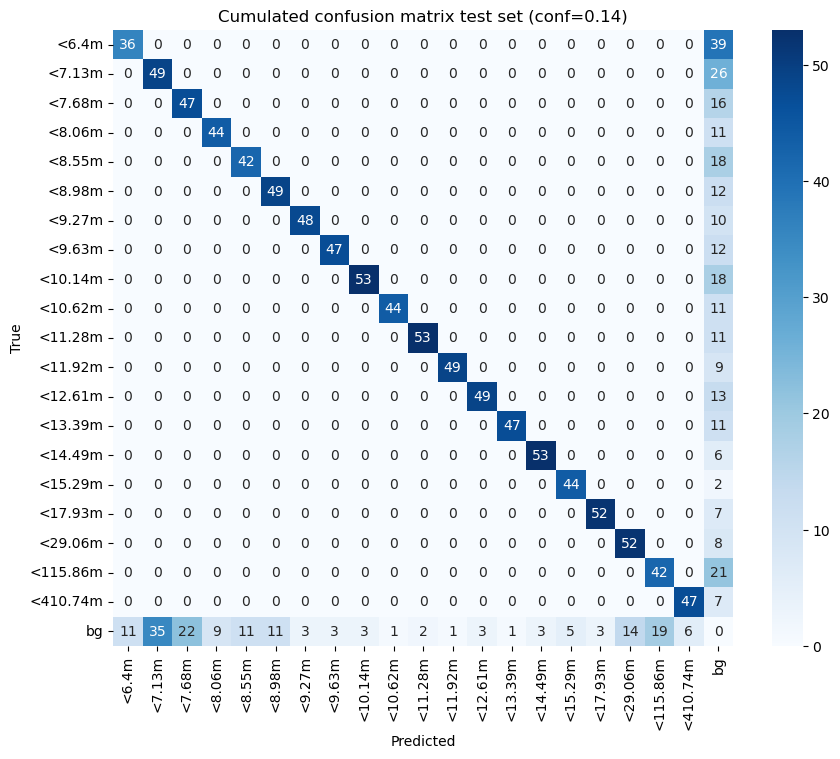

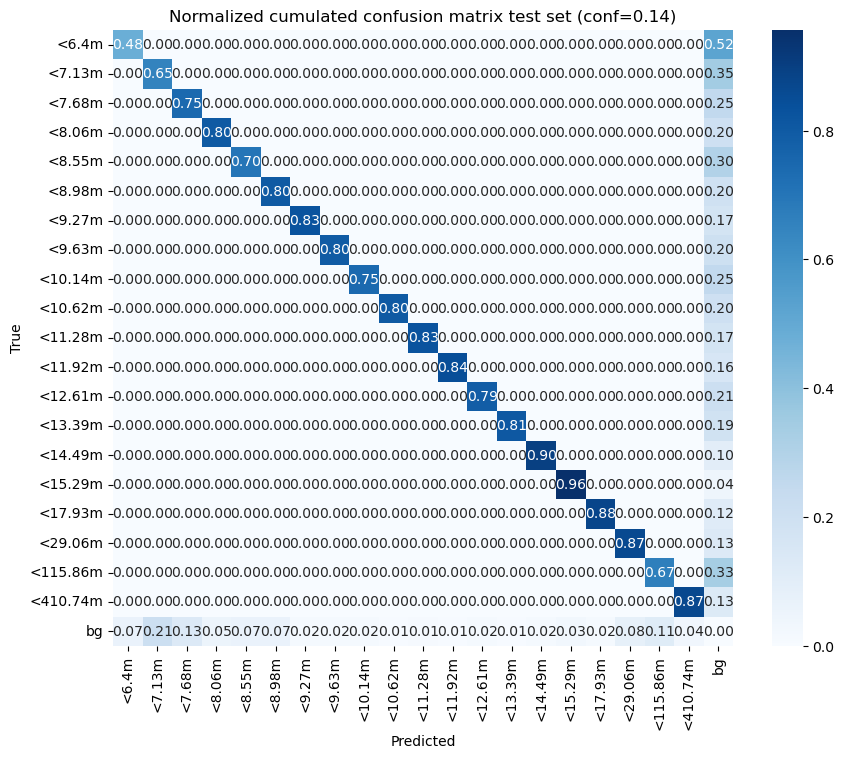

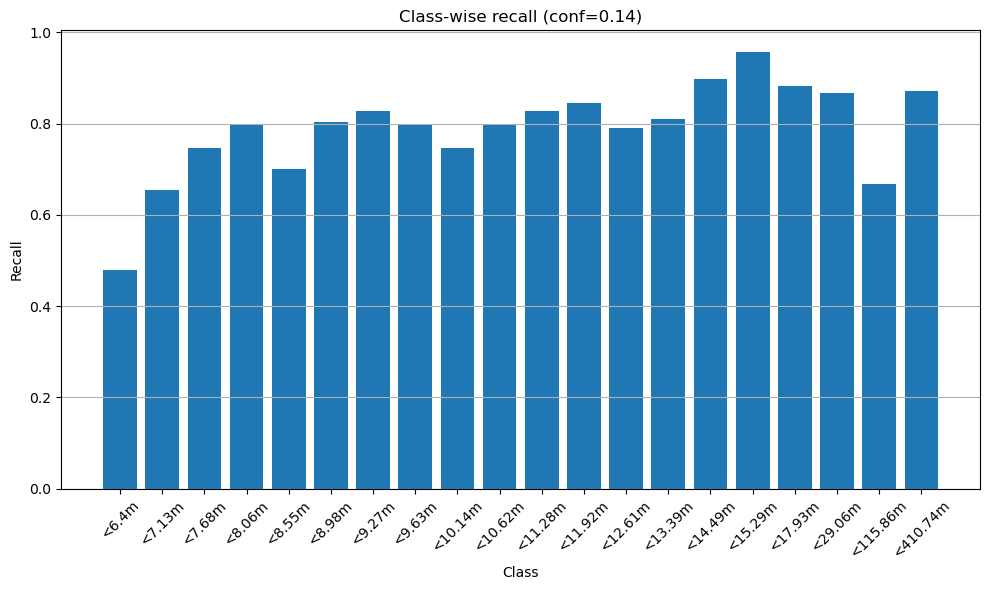

Confidence: 0.14 | Precision: {0: 0.766, 1: 0.583, 2: 0.681, 3: 0.83, 4: 0.792, 5: 0.817, 6: 0.941, 7: 0.94, 8: 0.946, 9: 0.978, 10: 0.964, 11: 0.98, 12: 0.942, 13: 0.979, 14: 0.946, 15: 0.898, 16: 0.945, 17: 0.788, 18: 0.689, 19: 0.887, 20: 0.0} | Recall: {0: 0.48, 1: 0.653, 2: 0.746, 3: 0.8, 4: 0.7, 5: 0.803, 6: 0.828, 7: 0.797, 8: 0.746, 9: 0.8, 10: 0.828, 11: 0.845, 12: 0.79, 13: 0.81, 14: 0.898, 15: 0.957, 16: 0.881, 17: 0.867, 18: 0.667, 19: 0.87, 20: 0.0} | F1 Score: {0: 0.59, 1: 0.616, 2: 0.712, 3: 0.815, 4: 0.743, 5: 0.81, 6: 0.881, 7: 0.863, 8: 0.834, 9: 0.88, 10: 0.891, 11: 0.908, 12: 0.859, 13: 0.887, 14: 0.921, 15: 0.927, 16: 0.912, 17: 0.826, 18: 0.678, 19: 0.878, 20: 0}


In [100]:
# --- Parameters ---
gt_folder = "tmp/groundtruth"
pred_folder = "tmp/predictions"
iou_threshold = 0.3
conf_list = [0.14]

labels = [f"<{i}m" for i in length_classes] + ["bg"]

all_precision = []
all_recall = []
all_f1 = []

for conf in conf_list:
    confidence_thresholds = {i: conf for i in range(len(length_classes))}
    cm = compute_confusion_matrix(gt_folder, pred_folder, iou_threshold, confidence_thresholds) # working on class "boat" only
    
    
    plot_confusion_matrix(cm, labels, title=f"Confusion matrix test set (conf={conf:.2f})")
    cmn = cm.copy()
    cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cmn, labels, title=f"Normalized confusion matrix test set (conf={conf:.2f})")

    cmm = cm.copy()
    for i in range(len(cm[0])-1):
        tmp = cmm[i, :-1].sum()
        # cmm[:-1, i] = 0
        cmm[i, :-1] = 0
        cmm[i, i] = tmp
    plot_confusion_matrix(cmm, labels, title=f"Cumulated confusion matrix test set (conf={conf:.2f})")
    cmmn = cmm.copy()
    cmmn = cmmn.astype('float') / cmmn.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cmmn, labels, title=f"Normalized cumulated confusion matrix test set (conf={conf:.2f})")

    # get diagonal of cmmn
    diag = np.diag(cmmn)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(diag[:-1])), diag[:-1])
    plt.xlabel("Class")
    plt.ylabel("Recall")
    plt.title(f"Class-wise recall (conf={conf:.2f})")
    plt.xticks(range(len(labels[:-1])), labels[:-1], rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    precision, recall, f1 = compute_precision_recall_f1(cmm)
    print(f"Confidence: {conf:.2f} | Precision: {precision} | Recall: {recall} | F1 Score: {f1}")
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)




In [ ]:
for i in range(len(conf_list)):
    conf = conf_list[i]
    precision = all_precision[i].copy()
    recall = all_recall[i].copy()
    f1 = all_f1[i].copy()

    # remove last elements of dict
    precision.popitem()
    recall.popitem()
    f1.popitem()

    plt.figure(figsize=(10, 6))
    plt.plot(precision.keys(), precision.values(), label=f'Precision (conf={conf:.2f})', linestyle='--')
    plt.scatter(precision.keys(), precision.values(), s=10)
    plt.plot(recall.keys(), recall.values(), label=f'Recall (conf={conf:.2f})', linestyle='--')
    plt.scatter(recall.keys(), recall.values(), s=10)
    plt.plot(f1.keys(), f1.values(), label=f'F1 Score (conf={conf:.2f})')
    plt.scatter(f1.keys(), f1.values(), s=10)

    plt.title(f'Precision, Recall and F1 Score Curves (conf={conf:.2f})')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.xticks(range(len(length_classes)), [f'<{length_classes[i]}m' for i in range(len(length_classes))])
    plt.legend()
    plt.grid()
    plt.show()


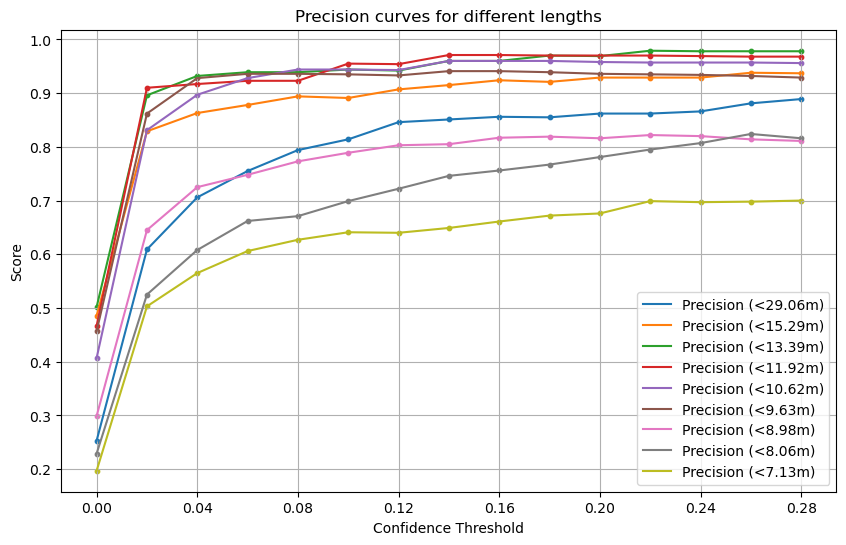

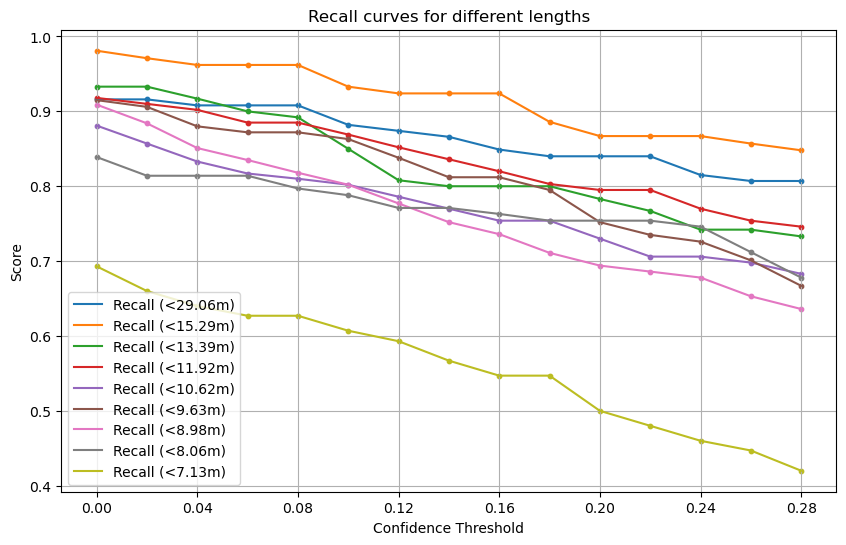

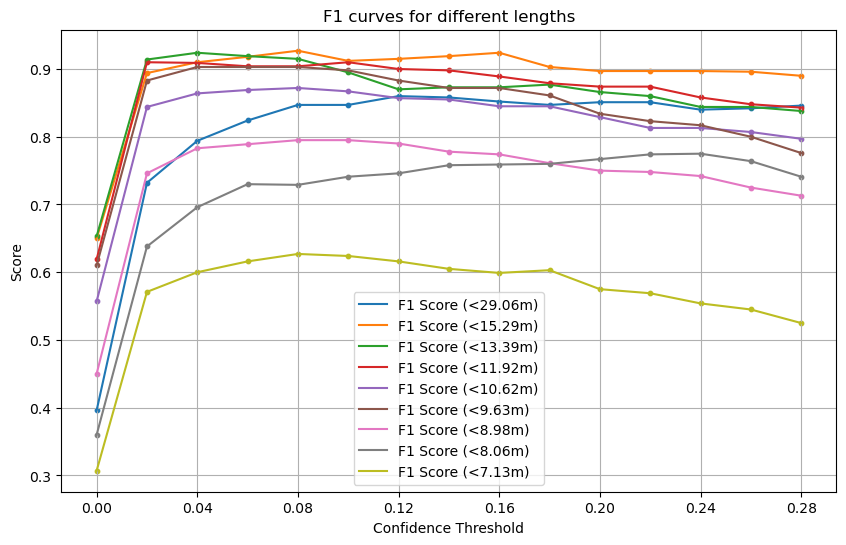

In [36]:
plt.figure(figsize=(10, 6))
for class_id in range(len(length_classes)-1, -1, -1):
    plt.plot(conf_list, [all_precision[i][class_id] for i in range(len(all_precision))], label=f'Precision (<{length_classes[class_id]}m)')
    plt.scatter(conf_list, [all_precision[i][class_id] for i in range(len(all_precision))], s=10)

plt.title('Precision curves for different lengths')
plt.xlabel('Confidence Threshold')
plt.ylabel('Score')
plt.xticks([conf_list[i] for i in range(0, len(conf_list), 2)])
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for class_id in range(len(length_classes)-1, -1, -1):
    plt.plot(conf_list, [all_recall[i][class_id] for i in range(len(all_recall))], label=f'Recall (<{length_classes[class_id]}m)')
    plt.scatter(conf_list, [all_recall[i][class_id] for i in range(len(all_recall))], s=10)

plt.title('Recall curves for different lengths')
plt.xlabel('Confidence Threshold')
plt.ylabel('Score')
plt.xticks([conf_list[i] for i in range(0, len(conf_list), 2)])
plt.grid()
plt.legend()
plt.show()



plt.figure(figsize=(10, 6))
for class_id in range(len(length_classes)-1, -1, -1):
    plt.plot(conf_list, [all_f1[i][class_id] for i in range(len(all_f1))], label=f'F1 Score (<{length_classes[class_id]}m)')
    plt.scatter(conf_list, [all_f1[i][class_id] for i in range(len(all_f1))], s=10)

plt.title('F1 curves for different lengths')
plt.xlabel('Confidence Threshold')
plt.ylabel('Score')
plt.xticks([conf_list[i] for i in range(0, len(conf_list), 2)])
plt.grid()
plt.legend()
plt.show()


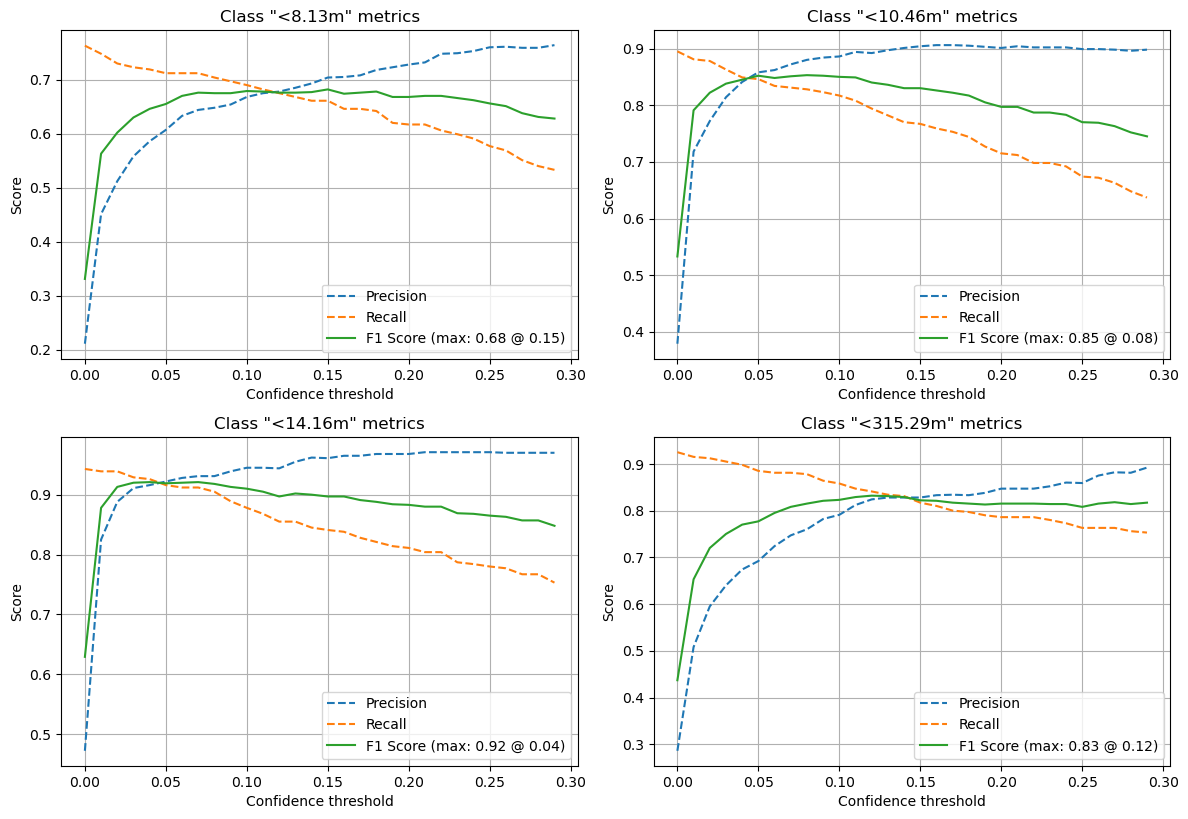

In [271]:
plt.figure(figsize=(12, len(length_classes) * 4))
for class_id in range(len(length_classes)):

    precisions = [all_precision[i][class_id] for i in range(len(all_precision))]
    recalls = [all_recall[i][class_id] for i in range(len(all_recall))]
    f1_scores = [all_f1[i][class_id] for i in range(len(all_f1))]

    plt.subplot(len(length_classes), 2, class_id + 1)
    plt.plot(conf_list, precisions, label=f'Precision', linestyle='--')
    plt.plot(conf_list, recalls, label=f'Recall', linestyle='--')
    plt.plot(conf_list, f1_scores, label=f'F1 Score (max: {max(f1_scores):.2f} @ {conf_list[f1_scores.index(max(f1_scores))]:.2f})')
    plt.title(f'Class "<{length_classes[class_id]}m" metrics')
    plt.xlabel('Confidence threshold')
    plt.ylabel('Score')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()